## Nonlinear curve fitting

Here we use the multivariable Newton (or quasi-Newton with approximate derivatives) root finding to find parameters for a nonlinear equation to approximate some data.

We describe the new pieces then show how to solve a complete non-linear equation fitting problem.

Textbook sections [4.6](https://tobydriscoll.net/fnc-julia/nonlineqn/quasinewton.html) and 4.7.


## Finite difference Jacobian

Instead of writing a separate function for the matrix of first partial derivatives (Jacobian), make a numerical approximation using the Newton quotient:
      
$$\frac{df}{dx} \approx \frac{f(x+h)-f(x)}{h}.$$

Pick a small $h$. Traditional values are the square root of the machine epsilon.

We need to compute a derivative for each function with respect to each independent variable and store those in a matrix.

Here is the textbook implementation Function 4.6.1.


In [5]:
using LinearAlgebra
"""
    fdjac(f,x₀[,y₀])

Compute a finite-difference approximation of the Jacobian matrix for
`f` at `x₀`, where `y₀`=`f(x₀)` may be given.
"""
function fdjac(f,x₀,y₀=f(x₀))
    δ = sqrt(eps())*max(norm(x₀),1)   # FD step size
    m,n = length(y₀),length(x₀)
    if n==1
        J = (f(x₀+δ) - y₀) / δ
    else
        J = zeros(m,n)
        x = copy(x₀)
        for j in 1:n
            x[j] += δ
            J[:,j] = (f(x) - y₀) / δ
            x[j] -= δ
        end
    end
    return J
end

fdjac

Test this function using an example known pair of f and its Jacobian.

In [2]:
function func(x)
    [  exp(x[2]-x[1]) - 2,
       x[1]*x[2] + x[3],
       x[2]*x[3] + x[1]^2 - x[2]
    ];
end;
   
function jac(x)
    [ 
      -exp(x[2]-x[1])  exp(x[2]-x[1])   0
       x[2]            x[1]             1
       2*x[1]          x[3]-1           x[2]
    ];
end;

In [3]:
jac([1, 2, 3])

3×3 Matrix{Float64}:
 -2.71828  2.71828  0.0
  2.0      1.0      1.0
  2.0      2.0      2.0

In [7]:
fdjac(func, [1.0, 2.0, 3.0])

3×3 Matrix{Float64}:
 -2.71828  2.71828  -7.96501e-9
  2.0      1.0       1.0
  2.0      2.0       2.0

In [19]:
z = randn(3) .* 20
jac(z) .- fdjac(func, z)

3×3 Matrix{Float64}:
 -4.50313e-11   4.50313e-11  0.0
  2.98531e-9    8.98576e-9   9.379e-10
 -5.10274e-7   -1.12308e-7   3.07877e-8

### Broyden's update

This is a technique for reducing the number of evaluations of the Jacobian. See textbook for some of the details.

## Levenberg's method

Newton's method to solve $f(x) = 0$ uses an iteration $x_{k+1} = x_k - J^{-1}(x_k)f(x_k)$.

We find the increment ($s_k = x_{k+1}-x_k$) by solving a linear system $A_ks_k = -f(x_k)$ where $A_k$ is a finite difference approximation to the Jacobian.

If the system is not square we solve the system $A_k^TA_ks_k = -A_k^Tf(x_k)$.

Sometimes Newton's method "improves" a solution by moving farther from a root. An alternative is to use the gradient to move strictly "downhill". Levenberg's method is an adaptive fusion that combines both approaches. 

We take a Newton step by solving $A_k^TA_ks_k = -A_k^Tf(x_k)$.

A gradient (steepest descent) step is obtained from the gradient of the inner product of $f(x_k)$ with itself ($f^T(x_k)f(x_k)$) which is $\nabla f(x_k) = 2J^T(x_k)f(x_k)$. Thus a steepest-descent step is $s_k = -A^T_k f(x_k)$ (see textbook for details.)

Levenberg uses a "combination" with a parameter $\lambda$ by solving 

$$(A^T_kA_k + \lambda I)s_k = -A^T_k f(x_k).$$

The value of $\lambda$ is changed each iteration depending on how well the method is working.

There is one other optimization. Broyden's update is used to avoid recomputing a Jacobian matrix at each iteration. See textbook for details.


In [10]:
"""
    levenberg(f,x₁[;maxiter,ftol,xtol])

Use Levenberg's quasi-Newton iteration to find a root of the system
`f` starting from `x₁`. Returns the history of root estimates 
as a vector of vectors.

The optional keyword parameters set the maximum number of iterations
and the stopping tolerance for values of `f` and changes in `x`.

"""
function levenberg(f,x₁;maxiter=40,ftol=1e-12,xtol=1e-12)
    x = [float(x₁)]
    yₖ = f(x₁)
    k = 1;  s = Inf;
    A = fdjac(f,x[k],yₖ)   # start with FD Jacobian
    jac_is_new = true

    λ = 10;
    while (norm(s) > xtol) && (norm(yₖ) > ftol)
        # Compute the proposed step.
        B = A'*A + λ*I
        z = A'*yₖ
        s = -(B\z)
        
        x̂ = x[k] + s
        ŷ = f(x̂)

        # Do we accept the result?
        if norm(ŷ) < norm(yₖ)    # accept
            λ = λ/10   # get closer to Newton
            # Broyden update of the Jacobian.
            A += (ŷ-yₖ-A*s)*(s'/(s'*s))
            jac_is_new = false
            
            push!(x,x̂)
            yₖ = ŷ
            k += 1
        else                       # don't accept
            # Get closer to gradient descent.
            λ = 4λ
            # Re-initialize the Jacobian if it's out of date.
            if !jac_is_new
                A = fdjac(f,x[k],yₖ)
                jac_is_new = true
            end
        end

        if k==maxiter
            @warn "Maximum number of iterations reached."
            break
        end
        
    end
    return x
end

levenberg

Now we solve the same nonlinear system as before, obtaining the same solution, but without the need to provide a Jacobian function. We check to see it takes about the same amount of time as the newtonsys function used earlier.

In [12]:
@time x = levenberg(func,[0,0,0])

  0.000081 seconds (186 allocations: 17.188 KiB)


12-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0]
 [-0.08396946536317919, 0.07633587873004255, 0.0]
 [-0.42205075841965206, 0.21991260740534585, 0.012997569823167984]
 [-0.48610710938504953, 0.2138968287772044, 0.09771872586402451]
 [-0.45628390809556546, 0.24211047709245145, 0.10100440258901365]
 [-0.4556388336696561, 0.23470443548745376, 0.10854665717226099]
 [-0.45839614510679244, 0.2353095686241835, 0.10739828073307472]
 [-0.45804340381597397, 0.2351212406112955, 0.10768079583159752]
 [-0.45803332584412787, 0.23511390840121466, 0.10768998049540802]
 [-0.45803327880719313, 0.23511389867393448, 0.10768999250671268]
 [-0.4580332805601996, 0.2351138998630789, 0.10768999097568899]
 [-0.458033280641234, 0.23511389991865284, 0.10768999090414473]

## Nonlinear curve fitting

The solution to fitting a curve to data is now simple. We want to find the value of $x$ that minimizes $\| f(x)\|_2$. 

Once again we use a Taylor series linear approximation to estimate $f$ at a new point $x_{k+1}$, given a starting value $x_k$.

$$ q = f(x_k) + J (x_{k+1}- x_k)$$

since the system is overdetermined (more data points than parameters), we won't be able to solve this for $q=0$. Instead we define $x_{k+1}$ as the value that minimizes $\|q\|_2$.

This is the same problem we've already solved!

The function $f$ represents the sum of squared differences between the function and the data as a function of the parameters. This is traditionally called the "loss" or "misfit" function.

As an example we will solve exercise 4.7.3.

A famous result by Kermack and McKendrick in 1927 suggests that in epidemics that kill only a 
small fraction of a susceptible population, the death rate as a function of time is well modeled by
$$w'(t) = A \text{sech}^2(B(t-C))$$
for constant values of the parameters $A, B, C$. Since the maximum of $\text{sech}$ is $\text{sech}(0) = 1$,
$A$ is the maximum death rate and $C$ is the time of peak deaths. 

Use this model to fit the deaths per week from plague recorded in Mumbai during 1906:

Notice that this model is not linear in the parameters $B$ and $C$ so we can't use linear regression. Instead we use our non-linear solver `levenberg`.

In [13]:
deaths_per_week = [
  5, 10, 17, 22, 30, 50, 51, 90, 120, 180, 292, 395, 445, 775, 780,
  700, 698, 880, 925, 800, 578, 400, 350, 202, 105, 65, 55, 40, 30, 20
  ];
week = 1:length(deaths_per_week);

(a) Use Function 4.6.4 to find the best least-squares fit to the data using the $\sech^2$
model. Make a plot of the model fit superimposed on the data.

(b) Repeat part (a) using only the first 15 data values.


solution[end] = [853.5715638143683, -0.17229190389170182, 17.296895732017227]


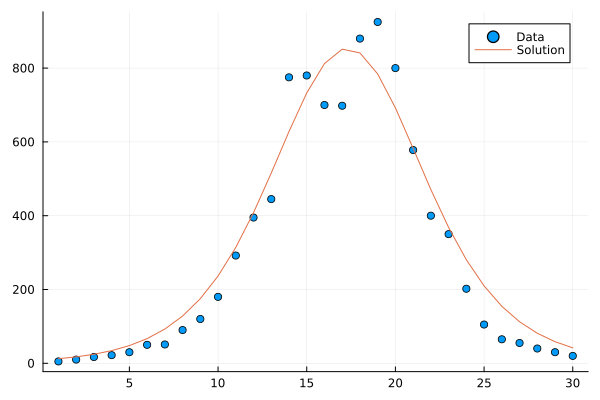

In [14]:
function f(x) 
    A, B, C = x
    @. A * (sech(B * (week - C)) )^2
end
function misfit(x)
   (f(x) .- deaths_per_week) .^2
end
solution = levenberg(misfit, [800, 10, 15])
@show solution[end]

using Plots
scatter(week, deaths_per_week, label = "Data")
plot!(week, f(solution[end]), label = "Solution")


Part (b)

solution[end] = [877.7409749730585, 0.2585989966281243, 15.894052903474618]


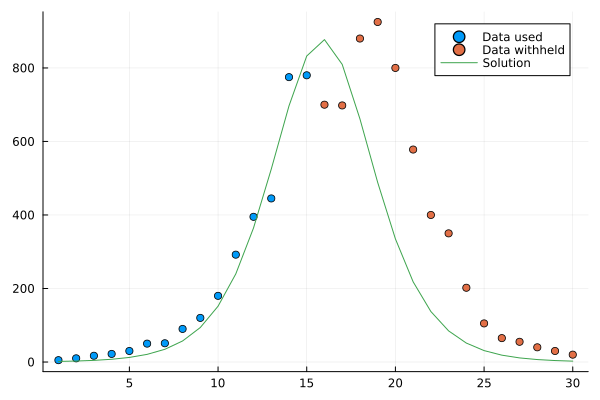

In [15]:
function misfit(x)
   s = (f(x) .- deaths_per_week) .^2
   s[1:15]
end
solution = levenberg(misfit, [800, 10, 15])
@show solution[end]

scatter(week[1:15], deaths_per_week[1:15], label = "Data used")
scatter!(week[16:end], deaths_per_week[16:end], label = "Data withheld")
plot!(week, f(solution[end]), label = "Solution")


In the homework you will adapt this to find the equation of a circle passing through a set of data.

Solving a problem of this complexity is still very fast -- about 2 milliseconds.

In [16]:
@time levenberg(misfit, [800, 10, 15])

  0.002646 seconds (7.31 k allocations: 458.297 KiB)


33-element Vector{Vector{Float64}}:
 [800.0, 10.0, 15.0]
 [799.9984728611838, 9.998828405534697, 14.989746409632886]
 [800.0149127839627, 9.999574971633816, 14.981526203853116]
 [800.0150725907772, 9.957153451126237, 14.982506615115403]
 [800.0166129406105, 9.547587733394945, 14.98444053072211]
 [800.0406581928216, 3.153893442638961, 15.011616979961024]
 [800.0408459478879, 2.8350082911885326, 14.01964776838589]
 [800.0369119144864, 2.780330913035961, 14.576407359971082]
 [800.0396548318847, 0.7040765818414165, 14.48238344766341]
 [800.0357874759218, 0.6102014663982933, 14.480288294706947]
 [798.7702588370661, 0.42655648428583115, 14.476375245642208]
 [798.5452907365766, 0.36975355588343234, 14.474918866609197]
 [798.3839508254006, 0.2545865528952288, 15.284583573731254]
 ⋮
 [877.9159355725607, 0.25856898087533153, 15.894918762021788]
 [877.7421601669269, 0.25856042676826524, 15.894554320797827]
 [877.8410601896447, 0.25855909913679925, 15.894845917666174]
 [877.7348496975611, 0.258591

You can easily modify the misfit function -- to use absolute deviations instead of squared deviations.

solution[end] = [882.6487554840888, -0.1884475671751243, 17.338930745459876]


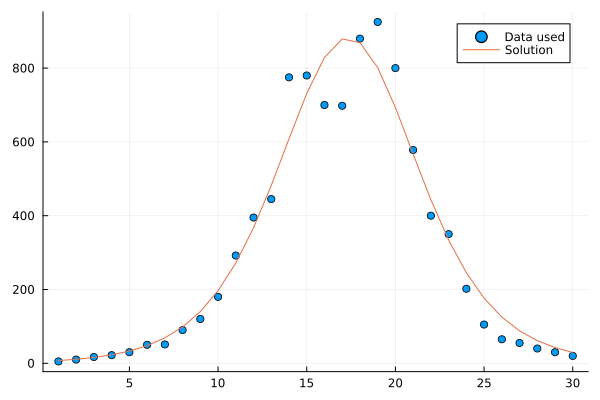

In [83]:
function misfit(x)
   s = abs.(f(x) .- deaths_per_week)
   # s = (f(x) .- deaths_per_week) .^ 2
end
solution = levenberg(misfit, [800, 10, 15])
@show solution[end]

scatter(week, deaths_per_week, label = "Data used")
plot!(week, f(solution[end]), label = "Solution")


You can try to use a nonlinear solver. Here we give it only the sum of squared residuals. If your initial guess is poor, the result will be a bad fit or a failure to converge (find an optimium). It's also much slower.

Levenberg's method that combines the steepest descent and Newton's method is quite a clever idea!

In [17]:
using NLsolve
function misfit2(x)
   # s = sum((f(x) .- deaths_per_week) .^ 2 )
    z = (f(x) .- deaths_per_week)
    z' * z
end

misfit2 (generic function with 1 method)

In [18]:
@time s = nlsolve(misfit2, [880.0, 0.25, 17.0], autodiff = :forward)  # requires ForwardDiff package

  0.791926 seconds (5.42 M allocations: 275.549 MiB, 6.42% gc time, 89.55% compilation time)


Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [880.0, 0.25, 17.0]
 * Zero: [879.5461764402099, 0.18740914747020443, 17.104594973033404]
 * Inf-norm of residuals: 132850.700896
 * Iterations: 1000
 * Convergence: false
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: false
 * Function Calls (f): 249
 * Jacobian Calls (df/dx): 132

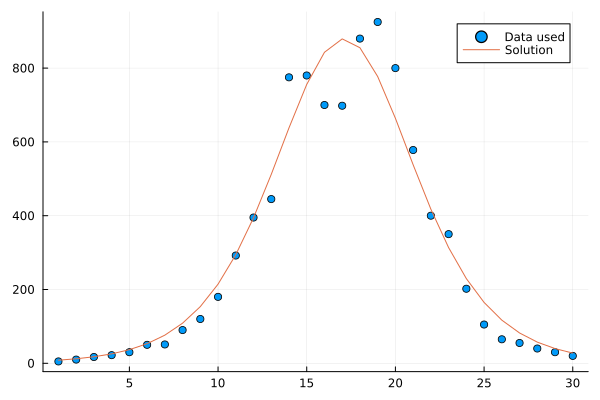

In [145]:
scatter(week, deaths_per_week, label = "Data used")
plot!(week, f(s.zero), label = "Solution")
